In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import Callback

In [2]:
dataframe = pd.read_excel("fitur_with_resprate.xlsx")
dataframe

,HR,SDNN,RMSSD,SDSD,pNN50,LF,HF,LF/HF,SD1,SD2,SD_ratio,Respiratory Rate,Label
0,80.568431,222.274826,368.223786,195.355517,93.150685,0.047852,0.304688,0.005376,260.373536,173.951093,0.668083,17.582506,0
1,81.446682,226.661296,381.289425,188.988957,94.557823,0.063477,0.300781,0.006305,269.612314,173.348284,0.642954,18.107391,0
2,79.320992,215.497094,351.052520,197.086881,93.750000,0.041016,0.295898,0.006535,248.231445,176.696145,0.711820,17.138070,0
3,83.278523,235.231443,399.870160,171.497801,96.969697,0.046875,0.322266,0.007597,282.749667,174.284190,0.616390,19.223684,0
4,81.458408,235.122362,396.694950,188.722372,97.260274,0.051758,0.328125,0.008252,280.505539,178.458196,0.636202,18.648022,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1798,200.387542,1018.682901,1066.921911,989.214928,93.243243,0.040039,0.150391,49.101431,750.012748,746.971950,0.995946,11.054482,0
1799,82.918378,69.268236,16.409353,11.457858,1.226994,0.047852,0.172852,49.525937,11.602552,97.246573,8.381482,15.119709,1
1800,90.657909,65.795606,9.850426,5.964804,0.000000,0.052734,0.180664,50.408359,6.963794,92.741201,13.317626,15.286906,0
1801,80.031242,72.801562,17.842106,11.082467,0.318471,0.045898,0.151367,51.246217,12.608152,101.761822,8.071113,15.134702,1


In [3]:
X = dataframe[
    ["LF/HF", "SD_ratio", "LF", "SD1", "RMSSD", "pNN50", "SDSD", "Respiratory Rate"]
]
num_feature = len(X.columns)

y = dataframe["Label"]

In [4]:
smote = SMOTE(random_state=42)
data_resampled, labels_resampled = smote.fit_resample(X, y)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    data_resampled, labels_resampled, test_size=0.1, shuffle=True
)

In [6]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get("accuracy") >= 0.90:
            print("\nAkurasi telah mencapai 90%, menghentikan training.")
            self.model.stop_training = True

In [7]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units=64, input_shape=(num_feature,), activation="relu"),
        tf.keras.layers.Dense(
            units=512,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.01),
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
            units=256,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.01),
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
            units=128,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.01),
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

c:\Users\ASUS\anaconda3\envs\cuda-env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
num_folds = 10  # Jumlah lipatan
accuracies = []  # List untuk menyimpan skor akurasi
losses = []

callback = MyCallback()

kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=101)
for train_indices, val_indices in kfold.split(X_train, y_train):
    x_training = X_train.iloc[train_indices]
    y_training = np.array(y_train)[train_indices]
    x_testing = X_train.iloc[val_indices]
    y_testing = np.array(y_train)[val_indices]

    # Proses pelatihan model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-5),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    history = model.fit(
        x_training, y_training, epochs=1000, batch_size=16, callbacks=[callback]
    )

    # Evaluasi model pada data validasi
    loss, accuracy = model.evaluate(x_testing, y_testing)
    accuracies.append(accuracy)
    losses.append(loss)

Epoch 1/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4657 - loss: 9.0450
Epoch 2/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5150 - loss: 8.7695
Epoch 3/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5092 - loss: 8.4976
Epoch 4/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4808 - loss: 8.9892
Epoch 5/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4847 - loss: 8.6847
Epoch 6/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4950 - loss: 8.8772
Epoch 7/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4985 - loss: 8.4784
Epoch 8/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4920 - loss: 8.3703
Epoch 9/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5013 - loss: 8.1347
Epoch 10/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4828 - loss: 8.3996
Epoch 11/1000
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4691 - loss: 8.4701
Epoch 12/1000
105/105 ━━━━━━━━

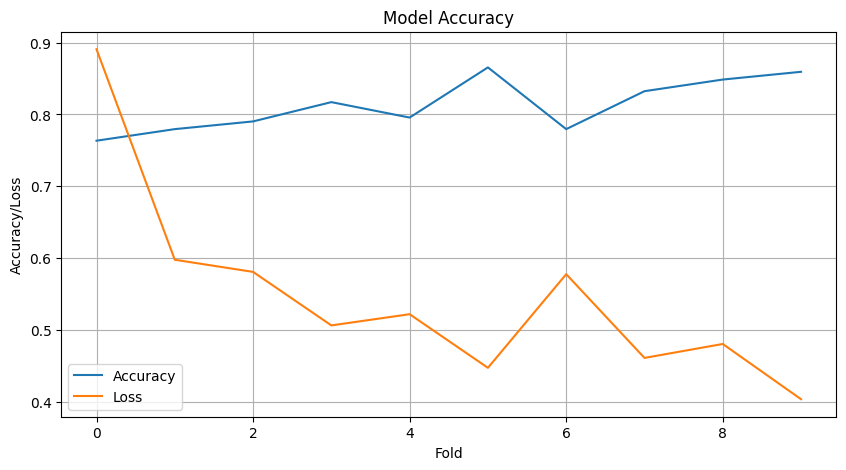

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label="Accuracy")
plt.plot(losses, label="Loss")
plt.legend()
plt.title("Model Accuracy")
plt.ylabel("Accuracy/Loss")
plt.xlabel("Fold")
plt.grid()

In [10]:
X_test

,LF/HF,SD_ratio,LF,SD1,RMSSD,pNN50,SDSD,Respiratory Rate
552,1.421637,1.700461,0.041016,13.512028,19.109059,0.332226,11.640212,16.831948
1249,4.111236,3.060127,0.057617,42.164357,59.632782,16.758242,49.017785,15.528905
1058,3.147601,2.227909,0.044922,105.325059,148.952129,16.568047,142.691620,14.854390
917,2.540791,2.845967,0.058594,5.629792,7.961963,0.000000,5.355380,16.210194
60,0.133097,0.795605,0.124023,68.805696,97.306020,37.573964,74.603778,15.402155
...,...,...,...,...,...,...,...,...
105,0.308476,1.066334,0.041016,47.000782,66.469160,2.686567,64.103070,16.991907
1220,3.943306,3.466366,0.059570,10.408270,14.720137,0.000000,9.580950,16.084037
1751,19.772765,6.499257,0.042969,10.565407,14.942303,0.664452,9.817087,16.196954
19,0.021131,0.615599,0.040039,284.672093,402.587134,99.303136,166.721577,20.571188


In [11]:
prediction = model.predict(X_test)
predicted_labels = (prediction > 0.5).astype(int)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Text(113.9222222222222, 0.5, 'predicted class')

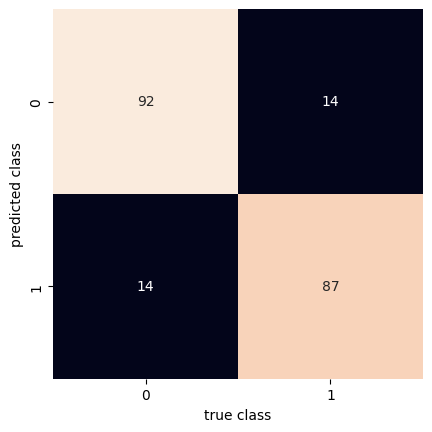

In [12]:
conmat = confusion_matrix(y_test, predicted_labels)

sns.heatmap(conmat.T, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("true class")
plt.ylabel("predicted class")